In [1]:
'''This notebook contains the implementations of the explicit inconsistency scores.'''

'This notebook contains the implementations of the explicit inconsistency scores.'

In [2]:
%matplotlib inline
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import torch
import segmentation_models_pytorch as smp
import albumentations as albu

import seaborn as sns
import pylab as py
import pandas as pd

from scripts.preprocessing import Dataset
from scripts.helper import plot_double_image, plot_triple_image, get_color_img, get_concat_h
from scripts.augmentation import get_training_augmentation, get_validation_augmentation, to_tensor, get_preprocessing, get_preprocessing_unlabeled

DEVICE = ('cuda:2' if torch.cuda.is_available() else 'cpu')

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import pylab as py
matplotlib.rcParams.update({                      # setup matplotlib to use latex for output
        "pgf.texsystem": "pdflatex",              # change this if using xetex or lautex
        "text.usetex": True,                      # use LaTeX to write all text
        "figure.figsize": (9, 5),                 # default fig size of 0.9 textwidth
        "figure.dpi": 300,
        "font.family": "serif",
        "font.serif": [],                         # blank entries should cause plots to inherit fonts from the document
        "font.sans-serif": [],
        "font.monospace": [],
        "axes.labelsize": 20,                     # LaTeX default is 10pt font.
        'axes.titlesize': 15,
        "font.size": 15,
        "legend.fontsize": 20,                    # Make the legend/label fonts a little smaller
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        })

In [4]:
##### Assign the location of your datasets

DATA_DIR = '/raid/maruf/data-800/'
# train set
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')
# validation set
x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')
# test set
x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [5]:
# encoder: resnext50
# encoder weights: imagenet
# segmentation model: FPN 

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['dorsal', 'adipose', 'caudal', 'anal', 
           'pelvic', 'pectoral', 'head', 'eye', 
           'caudal-ray', 'alt-ray', 'alt-spine', 'trunk']
ACTIVATION = 'sigmoid'
# segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name = ENCODER,
    encoder_weights = ENCODER_WEIGHTS,
    classes = len(CLASSES),
    activation = ACTIVATION,
)
# preprocessing function for this encoder
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [6]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation = get_training_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

# loading data from the dataset
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle=True, num_workers = 12)
valid_loader = DataLoader(valid_dataset, batch_size = 1, shuffle=False, num_workers = 4)
test_loader = DataLoader(test_dataset)

In [7]:
from scripts.helper import get_midpoint, get_row_col_mat, dorsal_to, anterior_to

In [8]:
def dorsal_to(pred_mask, sub_mask, obj_mask, row_mat): 
    max_sub = np.max(row_mat * sub_mask)
    max_obj = np.max(row_mat * obj_mask)

    return float(max(0, max_sub - max_obj) > 0)

In [9]:
def dorsal_to_batch(labelmaps, tensor=True):
    batch_size = labelmaps.shape[0]
    if tensor:
        y = labelmaps.detach().cpu().numpy()
    else:
        y = labelmaps
    penalty = 0
    for bs in range(batch_size):
        dorsal = y[bs, 0, :, :]
        adipose = y[bs, 1, :, :]
        caudal = y[bs, 2, :, :]
        anal = y[bs, 3, :, :]
        pelvic = y[bs, 4, :, :]
        pectoral = y[bs, 5, :, :]
        head = y[bs, 6, :, :]
        trunk = y[bs, 11, :, :]
        
        if dorsal.sum() == 0 or caudal.sum() == 0 or head.sum() == 0 or trunk.sum() == 0:
            continue
        dorsal_mid = get_midpoint(dorsal)
        caudal_mid = get_midpoint(caudal)
        head_mid = get_midpoint(head)
        trunk_mid = get_midpoint(trunk)
        row_mat, col_mat = get_row_col_mat(dorsal_mid, caudal_mid, head_mid, trunk_mid)
        
        if dorsal.sum() != 0 and pectoral.sum() != 0:
            penalty += dorsal_to(y[bs, :, :, :], dorsal, pectoral, row_mat)
            
        if dorsal.sum() != 0 and pelvic.sum() != 0:
            penalty += dorsal_to(y[bs, :, :, :], dorsal, pelvic, row_mat)
            
        if dorsal.sum() != 0 and anal.sum() != 0:
            penalty += dorsal_to(y[bs, :, :, :], dorsal, anal, row_mat)
            
    return penalty

In [10]:
def dorsal_to_nobatch(labelmap, tensor=True):
    if tensor:
        y = labelmap.detach().cpu().numpy()
    else:
        y = labelmap
        
    penalty = 0
    
    dorsal = y[0, :, :]
    adipose = y[1, :, :]
    caudal = y[2, :, :]
    anal = y[3, :, :]
    pelvic = y[4, :, :]
    pectoral = y[5, :, :]
    head = y[6, :, :]
    trunk = y[11, :, :]

    if dorsal.sum() == 0 or caudal.sum() == 0 or head.sum() == 0 or trunk.sum() == 0:
        return 0
    dorsal_mid = get_midpoint(dorsal)
    caudal_mid = get_midpoint(caudal)
    head_mid = get_midpoint(head)
    trunk_mid = get_midpoint(trunk)
    row_mat, col_mat = get_row_col_mat(dorsal_mid, caudal_mid, head_mid, trunk_mid)

    if dorsal.sum() != 0 and pectoral.sum() != 0:
        p_ = dorsal_to(y[ :, :, :], dorsal, pectoral, row_mat)
        penalty += p_
        if p_ > 0:
            print('dorsal-pectoral violation!')

    if dorsal.sum() != 0 and pelvic.sum() != 0:
        p_ = dorsal_to(y[ :, :, :], dorsal, pelvic, row_mat)
        penalty += p_
        if p_ > 0:
            print('dorsal-pelvic violation!')

    if dorsal.sum() != 0 and anal.sum() != 0:
        p_ = dorsal_to(y[ :, :, :], dorsal, anal, row_mat)
        penalty += p_
        if p_ > 0:
            print('dorsal-anal violation!')
        
    return penalty

In [11]:
explicit_penalty = 0
rn_penalty = 0

############# Explicit Penalty ##############
Trainloader:
Batch 1 penalty : 0.0
Batch 2 penalty : 0.0
Batch 3 penalty : 0.0
Batch 4 penalty : 0.0
Batch 5 penalty : 0.0
Batch 6 penalty : 0.0
Batch 7 penalty : 0.0
Batch 8 penalty : 0.0
Batch 9 penalty : 0.0
Batch 10 penalty : 0.0
Batch 11 penalty : 0.0
Batch 12 penalty : 0.0
Batch 13 penalty : 0.0
Batch 14 penalty : 0.0
Batch 15 penalty : 0.0
Batch 16 penalty : 0.0
Batch 17 penalty : 0.0
Batch 18 penalty : 0.0
Batch 19 penalty : 0.0
Batch 20 penalty : 0.0
Batch 21 penalty : 0.0
Batch 22 penalty : 0.0
Batch 23 penalty : 0.0
Batch 24 penalty : 0.0
Batch 25 penalty : 0.0
Batch 26 penalty : 0.0
Batch 27 penalty : 0.0
Batch 28 penalty : 0.0
Batch 29 penalty : 0.0
Batch 30 penalty : 0.0
Batch 31 penalty : 0.0
Batch 32 penalty : 0.0
Batch 33 penalty : 0.0
Batch 34 penalty : 0.0
Batch 35 penalty : 0.0
Batch 36 penalty : 0.0
Batch 37 penalty : 0.0
Testloader:
Batch 1 penalty : 0.0
Batch 2 penalty : 0.0
Batch 3 penalty : 0.0
Batch 4 penalty : 0.0

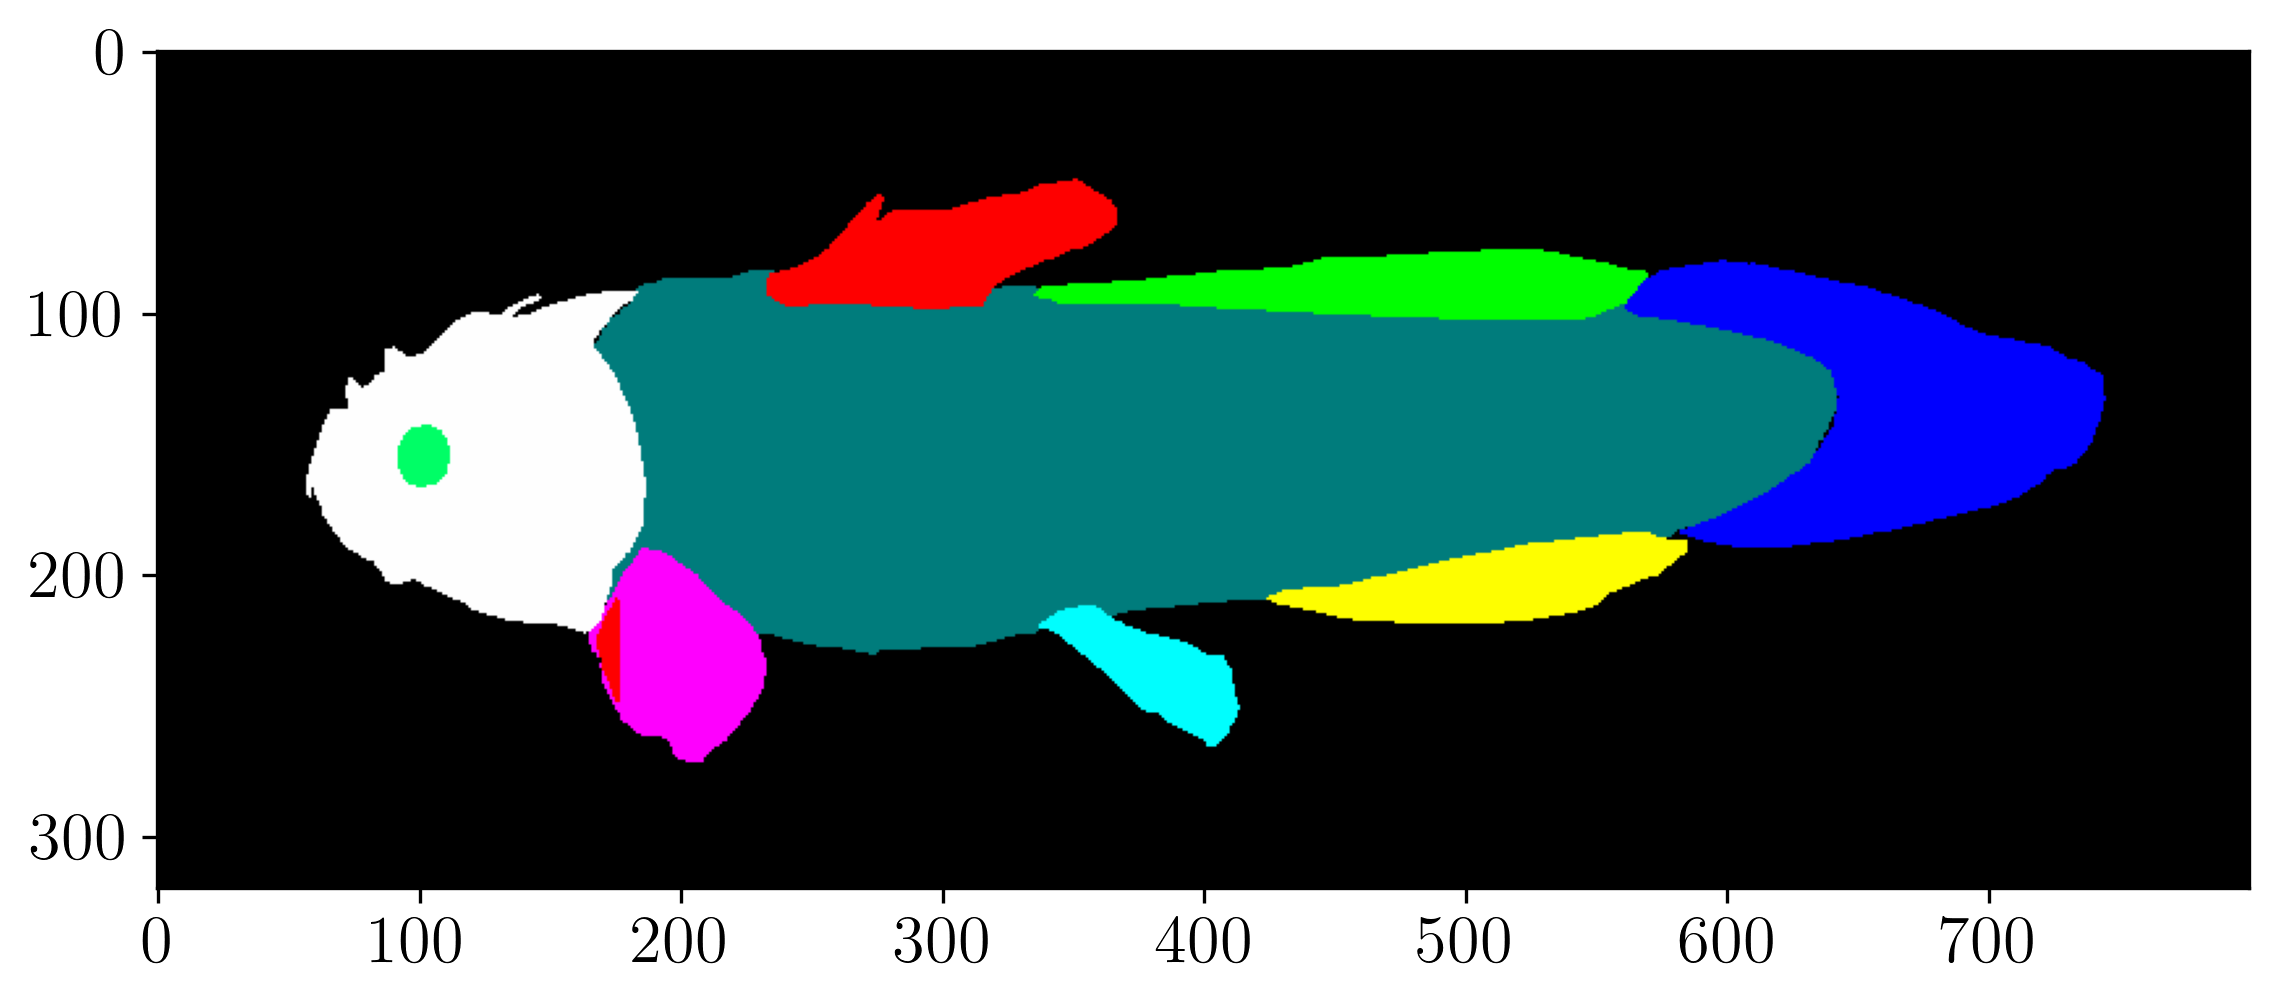

Batch 8 penalty : 1.0
Batch 9 penalty : 0.0
Batch 10 penalty : 0.0
Batch 11 penalty : 0.0
dorsal-pelvic violation!


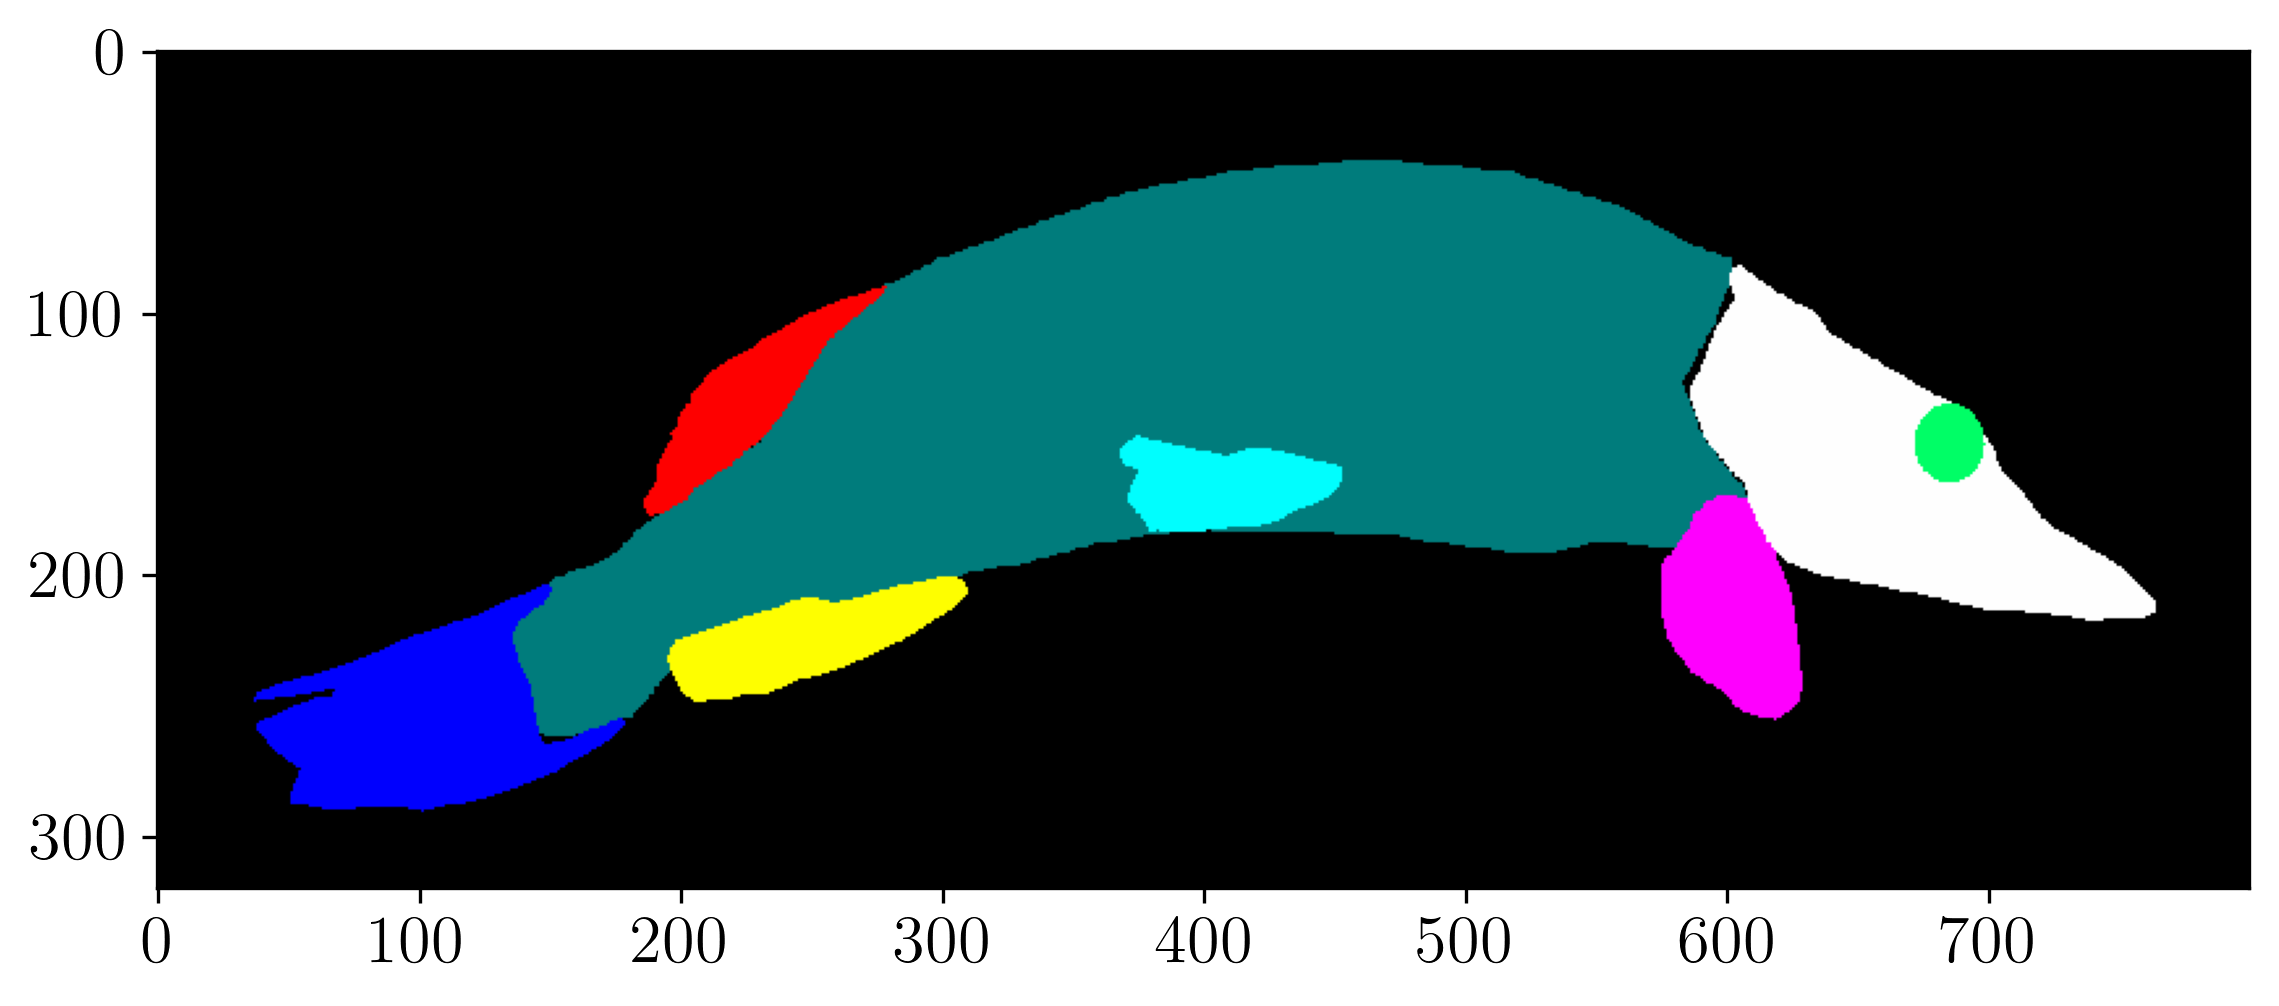

Batch 12 penalty : 1.0
Batch 13 penalty : 0.0
Batch 14 penalty : 0.0
Batch 15 penalty : 0.0
Batch 16 penalty : 0.0
Batch 17 penalty : 0.0
Batch 18 penalty : 0.0
Batch 19 penalty : 0.0
Batch 20 penalty : 0.0
Batch 21 penalty : 0.0
Batch 22 penalty : 0.0
Batch 23 penalty : 0.0
Batch 24 penalty : 0.0
Batch 25 penalty : 0.0
Batch 26 penalty : 0.0
Batch 27 penalty : 0.0
Batch 28 penalty : 0.0
Batch 29 penalty : 0.0
Batch 30 penalty : 0.0
Batch 31 penalty : 0.0
Batch 32 penalty : 0.0
Batch 33 penalty : 0.0
Batch 34 penalty : 0.0
Batch 35 penalty : 0.0
Batch 36 penalty : 0.0
Batch 37 penalty : 0.0
Batch 38 penalty : 0.0
Batch 39 penalty : 0.0
Batch 40 penalty : 0.0
Batch 41 penalty : 0.0
Batch 42 penalty : 0.0
Batch 43 penalty : 0.0
Batch 44 penalty : 0.0
Batch 45 penalty : 0.0
Batch 46 penalty : 0.0
Batch 47 penalty : 0.0
Batch 48 penalty : 0.0
Batch 49 penalty : 0.0
Batch 50 penalty : 0.0
Batch 51 penalty : 0.0
Batch 52 penalty : 0.0
Batch 53 penalty : 0.0
Batch 54 penalty : 0.0
Batch 55 pe

In [13]:
print('############# Explicit Penalty ##############')
print('Trainloader:')
batch_no = 0
for x, y in train_loader:
    batch_no += 1
    p_ = 0
    for y_ in y:
        p = dorsal_to_nobatch(y_)
        if p > 0:
            plt.imshow(get_color_img(y_, normal=False))
            plt.show()
        p_ += p
    print('Batch {} penalty : {}'.format(batch_no, p_))
    explicit_penalty += p_
    
print('Testloader:')
batch_no = 0
for x, y in test_loader:
    batch_no += 1
    p_ = 0
    for y_ in y:
        p = dorsal_to_nobatch(y_)
        if p > 0:
            plt.imshow(get_color_img(y_, normal=False))
            plt.show()
        p_ += p
    print('Batch {} penalty : {}'.format(batch_no, p_))
    explicit_penalty += p_
    
print('Validloader:')
batch_no = 0
for x, y in valid_loader:
    batch_no += 1
    p_ = 0
    for y_ in y:
        p = dorsal_to_nobatch(y_)
        if p > 0:
            plt.imshow(get_color_img(y_, normal=False))
            plt.show()
        p_ += p
    print('Batch {} penalty : {}'.format(batch_no, p_))
    explicit_penalty += p_

In [14]:
# Relational Network
from scripts.RN import RN
rn_model = RN().to(DEVICE)
rn_model.load_state_dict(torch.load('saved_models/rn_model.pt'))

<All keys matched successfully>

In [15]:
def dorsal_to_rn_batch(labelmaps, rn_model, tensor=True, device=DEVICE):
    if tensor == False:
        prediction = torch.tensor(labelmaps).float()
    else:
        prediction = labelmaps
    D = prediction[:, 0, :, :]
    Pel = prediction[:, 4, :, :]
    Pec = prediction[:, 5, :, :]
    An = prediction[:,3, :, :]
    H = prediction[:, 6, :, :]
    T = prediction[:, 2, :, :]
    
    penalty = 0
    
    # Dorsal-Pectoral
    if D.sum() != 0 and Pec.sum() != 0:
        rn_inp = torch.stack((H, T, D, Pec), dim=1).to(device)
        y_pred = rn_model(rn_inp)
        p_ = (y_pred<0.5).float().sum().item()
        if p_ > 0:
            print('dorsal-pectoral violation!')
        penalty += p_
    # Dorsal-Pelvic
    if D.sum() != 0 and Pel.sum() != 0:
        rn_inp = torch.stack((H, T, D, Pel), dim=1).to(device)
        y_pred = rn_model(rn_inp)
        p_ = (y_pred<0.5).float().sum().item()
        if p_ > 0:
            print('dorsal-pelvic violation!')
        penalty += p_
    # Dorsal-Anal
    if D.sum() != 0 and An.sum() != 0:
        rn_inp = torch.stack((H, T, D, An), dim=1).to(device)
        y_pred = rn_model(rn_inp)
        p_ = (y_pred<0.5).float().sum().item()
        if p_ > 0:
            print('dorsal-anal violation!')
        penalty += p_
    return penalty


def dorsal_to_rn_nobatch(labelmaps, rn_model, tensor=True, device=DEVICE):
    if tensor == False:
        prediction = torch.tensor(labelmaps).float()
    else:
        prediction = labelmaps
    labelmaps = torch.zeros(1, prediction.shape[0], prediction.shape[1], prediction.shape[2])
    labelmaps[0, :, :, :] = prediction
    
    return dorsal_to_rn_batch(labelmaps, rn_model, tensor=True, device=DEVICE)

In [18]:
print('############# RN Penalty ##############')
print('Trainloader:')
batch_no = 0
rn_penalty = 0
for x, y in train_loader:
    batch_no += 1
    p_ = 0
    for y_ in y:
        p = dorsal_to_rn_nobatch(y_, rn_model)
        if p > 0:
            plt.imshow(get_color_img(y_, normal=False))
            plt.show()
        p_ += p
    print('Batch {} penalty : {}'.format(batch_no, p_))
    rn_penalty += p_
    
print('Testloader:')
batch_no = 0
for x, y in test_loader:
    p_ = 0
    batch_no += 1
    for y_ in y:
        p = dorsal_to_rn_nobatch(y_, rn_model)
        if p > 0:
            plt.imshow(get_color_img(y_, normal=False))
            plt.show()
        p_ += p
    print('Batch {} penalty : {}'.format(batch_no, p_))
    rn_penalty += p_
    
print('Validloader:')
batch_no = 0
for x, y in valid_loader:
    p_ = 0
    batch_no += 1
    for y_ in y:
        p = dorsal_to_rn_nobatch(y_, rn_model)
        if p > 0:
            plt.imshow(get_color_img(y_, normal=False))
            plt.show()
        p_ += p
    print('Batch {} penalty : {}'.format(batch_no, p_))
    rn_penalty += p_

############# RN Penalty ##############
Trainloader:
Batch 1 penalty : 0.0
Batch 2 penalty : 0.0
Batch 3 penalty : 0.0
Batch 4 penalty : 0.0
Batch 5 penalty : 0.0
Batch 6 penalty : 0.0
Batch 7 penalty : 0.0
Batch 8 penalty : 0.0
Batch 9 penalty : 0.0
Batch 10 penalty : 0.0
Batch 11 penalty : 0.0
Batch 12 penalty : 0.0
Batch 13 penalty : 0.0
Batch 14 penalty : 0.0
Batch 15 penalty : 0.0
Batch 16 penalty : 0.0
Batch 17 penalty : 0.0
Batch 18 penalty : 0.0
Batch 19 penalty : 0.0
Batch 20 penalty : 0.0
Batch 21 penalty : 0.0
Batch 22 penalty : 0.0
Batch 23 penalty : 0.0
Batch 24 penalty : 0.0
Batch 25 penalty : 0.0
Batch 26 penalty : 0.0
Batch 27 penalty : 0.0
Batch 28 penalty : 0.0
Batch 29 penalty : 0.0
Batch 30 penalty : 0.0
Batch 31 penalty : 0.0
Batch 32 penalty : 0.0
Batch 33 penalty : 0.0
Batch 34 penalty : 0.0
Batch 35 penalty : 0.0
Batch 36 penalty : 0.0
Batch 37 penalty : 0.0
Testloader:
Batch 1 penalty : 0.0
Batch 2 penalty : 0.0
Batch 3 penalty : 0.0
Batch 4 penalty : 0.0
Batch

In [19]:
print('Explicit Penalty:', explicit_penalty)
print('Relational-Network Penalty:', rn_penalty)

Explicit Penalty: 2.0
Relational-Network Penalty: 0.0
